# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from collections import defaultdict

In [2]:
%matplotlib inline

# Read model predictions

In [3]:
path = "output/"

In [4]:
df = pd.read_csv(os.path.join(path, "error_beam_test.tsv"), delimiter="\t")
df_stats = pd.read_csv(os.path.join(path, "stats_pred.tsv"), delimiter="\t")

In [5]:
df.head()

,file,context,gold,generated,loss,bleu,f1_entity,context_length
0,MUL0003,i am looking for a place to stay . it needs to...,there are [value_count] hotel -s that meet you...,there are [value_count] hotel -s that meet you...,0,34.390006,99.850125,1
1,MUL0003,id name postcode area type stars [UNK] interne...,there are [value_count] guesthouse hotel -s in...,there are [value_count] hotel -s that meet you...,0,11.556661,49.937528,3
2,MUL0003,guesthouse hotel -s in various area -s . what ...,sure ! we will book you in a hotel with [value...,i would recommend the [hotel_name] . it s a [h...,0,0.286549,0.000000,5
3,MUL0003,you in a hotel with [value_count] stars . the ...,"you are booked at the [hotel_name] , [hotel_ad...",how many people will be staying ?,0,0.000065,0.000000,7
4,MUL0003,"<br> you are booked at the [hotel_name] , [hot...",i found [restaurant_name] would you like to bo...,i can book you at [restaurant_name] . would yo...,0,0.541532,99.850125,9


In [6]:
df.describe()

,loss,bleu,f1_entity,context_length
count,7372.0,7.372000e+03,7372.000000,7372.000000
mean,0.0,1.342643e+01,37.165074,8.135106
std,0.0,1.837514e+01,38.751242,5.385951
min,0.0,3.838319e-11,0.000000,1.000000
25%,0.0,1.174790e-02,0.000000,3.000000
50%,0.0,5.212465e-01,36.615259,7.000000
75%,0.0,2.280079e+01,66.600033,11.000000
max,0.0,1.000000e+02,99.930029,35.000000


# Correlation b/w Metrics

## [DEFINE] Context Length + Bleu bins

In [7]:
df['true_context_length'] = df.apply(lambda r: len(r['context'].split('<br>')), 1)

In [8]:
df['bleu_bin'] = df.apply(lambda r: r['bleu']//10, 1)

In [9]:
df.iloc[6844].context

'restaurant in the [restaurant_area] . postcode type phone food [UNK] address area name id reference <br> i am sorry , there are not any [restaurant_food] restaurant -s in the [restaurant_area] of town . would you like to try a different cuisine ? <br> how about an [restaurant_food] restaurant then ? postcode type phone food [UNK] address area name id reference'

In [10]:
df.sample(10)

,file,context,gold,generated,loss,bleu,f1_entity,context_length,true_context_length,bleu_bin
58,MUL0034,postcode id parking [UNK] address name <br> th...,the car is a [taxi_type] .,"yes , it is a [taxi_type] and the contact numb...",0,0.317368,66.577830,17,3,0.0
5317,PMUL3742,a list of [restaurant_pricerange] restaurant -...,yes we have a variety,there are [value_count] [restaurant_pricerange...,0,0.009429,0.000000,3,3,0.0
3788,PMUL1463,"hi , i am trying to plan a trip and could use ...",okay sounds great ! where are you headed ?,i can help you with that . where are you depar...,0,0.402767,0.000000,1,1,0.0
6970,SNG0611,[UNK] address area name id <br> [restaurant_na...,your reservation at [restaurant_name] for [val...,i was able to book a table for you at [restaur...,0,51.894628,57.085743,9,3,5.0
6180,PMUL4780,entrance name type [UNK] id postcode reference...,there are a lot of trains to choose from . wou...,i can help you with that . what day and time w...,0,9.853912,0.000000,5,3,0.0
6265,PMUL4919,destination id duration leaveat trainid depart...,"you can choose from [train_leaveat] , [train_l...",[train_trainid] leaves at [train_leaveat] and ...,0,0.440332,0.000000,11,3,0.0
5550,PMUL4025,[UNK] id entrance area address <br> it is a co...,"i can certainly look that up for you . ok , it...",the phone number for [attraction_name] is [att...,0,11.977758,66.577830,3,3,1.0
2583,MUL2347,<br> i am looking for a restaurant that serves...,how about [restaurant_name] at [restaurant_nam...,[restaurant_name] is located at [restaurant_ad...,0,0.010996,49.925062,5,4,0.0
2917,PMUL0079,where is a [value_count] star hotel located in...,"i have several options , almost all of which a...",there are [value_count] hotel -s that meet you...,0,0.000345,66.600033,1,1,0.0
4016,PMUL1844,are there any guesthouses in the [hotel_area] ...,there are [value_count] guesthouses in the [ho...,there are [value_count] guesthouses in the [ho...,0,70.423128,99.900050,1,1,7.0


In [11]:
df.iloc[2099]['generated']

'you are welcome , have a great day !'

In [12]:
df.iloc[2099]['gold']

'you are welcome . i am so glad i was able to assist you .'

## Bleu vs. Context Length/turns

Observing slight decrease in bleu with context length.
 - Would be interesting to compare high context length performance across models
 - Check how many samples are availble for training for different context length

<AxesSubplot:title={'center':'bleu'}, xlabel='context_length'>

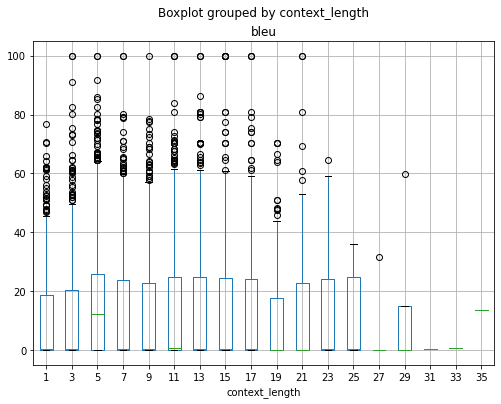

In [13]:
df.boxplot(column='bleu', by='context_length', figsize=(8,6))

<AxesSubplot:title={'center':'bleu_bin'}, xlabel='context_length'>

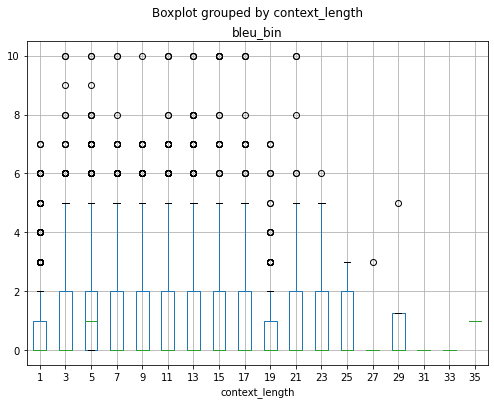

In [14]:
df.boxplot(column='bleu_bin', by='context_length', figsize=(8,6))

## [DEFINE] num_entities

In [15]:
regex_entity = r'\[([a-z\_\-]+)\]'

In [16]:
df['gold_entities'] = df.apply(lambda r: re.findall(regex_entity, r['gold']), 1)
df['num_entities'] = df.apply(lambda r: len(r['gold_entities']), 1)

<AxesSubplot:title={'center':'f1_entity'}, xlabel='num_entities'>

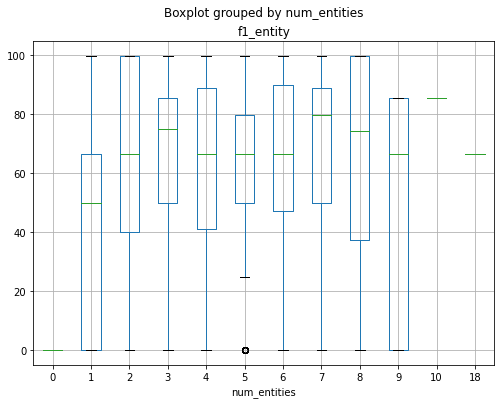

In [17]:
df.boxplot(column='f1_entity', by='num_entities', figsize=(8,6))

## [EXP] Scatter all pairs

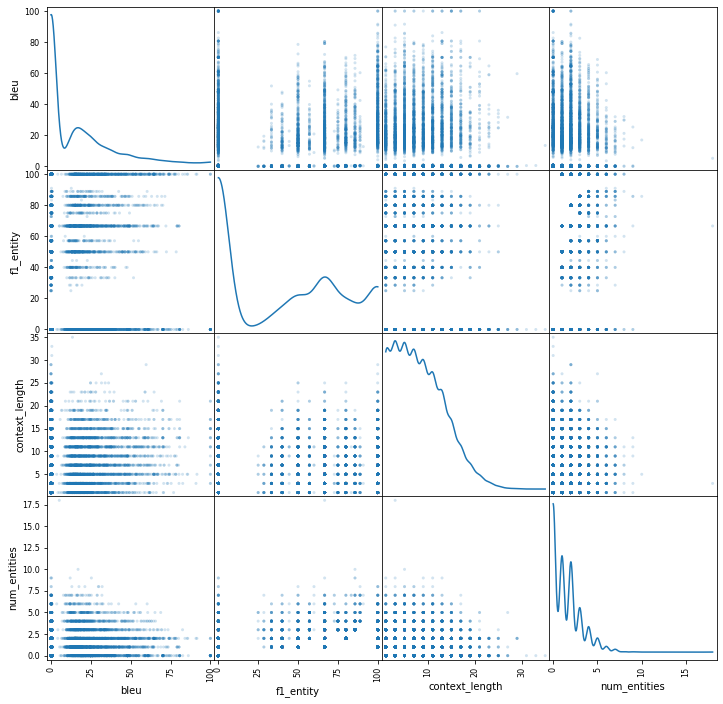

In [18]:
_ = scatter_matrix(df[['bleu', 'f1_entity', 'context_length', 'num_entities']], alpha=0.2, diagonal='kde', figsize=(12,12))

## [EXP] Entitywise Avg. f1-entity

In [19]:
entity_log = {
    'entity':[],
    'loss':[],
    'bleu':[],
    'f1_entity':[],
    'context_length':[]
}
for _, row in df.iterrows():
    for e in row['gold_entities']:
        entity_log['entity'].append(e)
        entity_log['loss'].append(row['loss'])
        entity_log['bleu'].append(row['bleu'])
        entity_log['f1_entity'].append(row['f1_entity'])
        entity_log['context_length'].append(row['context_length'])

In [20]:
df_entity_log = pd.DataFrame.from_dict(entity_log)

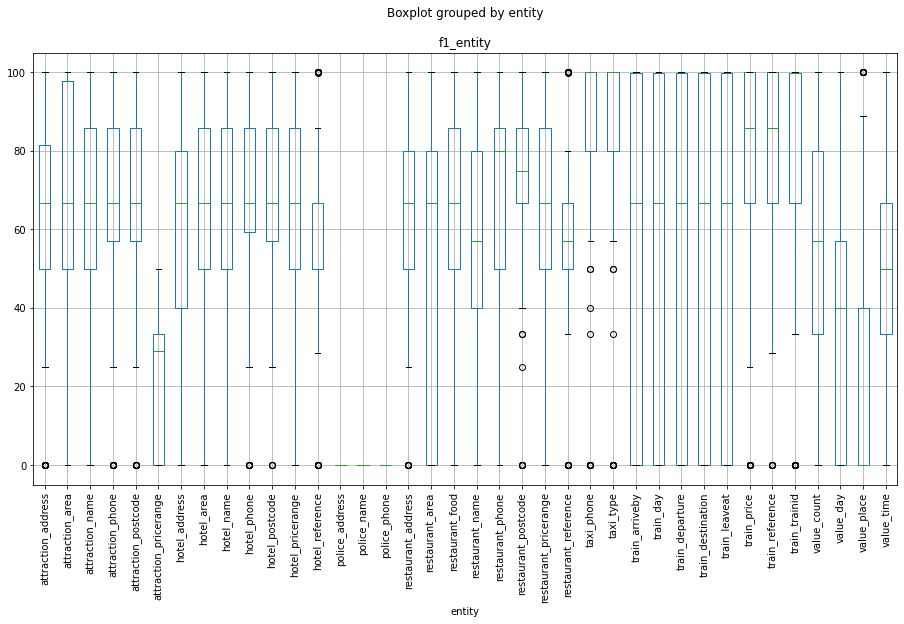

In [21]:
df_entity_log.boxplot(column='f1_entity', by='entity', figsize=(15,8))
_ = plt.xticks(rotation=90)

In [22]:
# df_entity_log.boxplot(column='loss', by='entity', figsize=(15,8))
# _ = plt.xticks(rotation=90)

## [DEFINE] Predicted Entities

In [23]:
df['pred_entities'] = df.apply(lambda r: re.findall(regex_entity, r['generated']), 1)
df['num_pred_entities'] = df.apply(lambda r: len(r['pred_entities']), 1)

In [24]:
df.sample(4)

,file,context,gold,generated,loss,bleu,f1_entity,context_length,true_context_length,bleu_bin,gold_entities,num_entities,pred_entities,num_pred_entities
6231,PMUL4884,[train_reference] . [hotel_name] is located in...,is there anything else i can do for you ?,"you are welcome , have a great day !",0,0.000371,0.000000,11,4,0.0,[],0,[],0
2922,PMUL0079,", do they have free parking ? phone food name ...",there is [restaurant_name] that serves [restau...,there are [value_count] [restaurant_pricerange...,0,0.009960,33.277837,11,3,0.0,"[restaurant_name, restaurant_food]",2,"[value_count, restaurant_pricerange, restauran...",4
4736,PMUL3012,address <br> that sounds like an exciting trip...,there is a beautiful park uniquely decorated w...,[attraction_name] is a nightclub in the [attra...,0,0.002635,0.000000,3,3,0.0,[],0,"[attraction_name, attraction_area]",2
1031,MUL0881,the table will be reserved for [value_count] m...,enjoy your day,thank you for contacting [value_place] towninf...,0,0.000316,0.000000,17,4,0.0,[],0,"[value_place, restaurant_area]",2


# Extracting Samples

## [SAMPLES] By Loss

In [25]:
def print_row(r):
    print(f"\n[CONTEXT]")
    
    print("{}".format('\n'.join(r['context'].split('<br>')[-5:])))
    
    print(f"\n[GOLD]: {r['gold']}")
    
    print(f"\n[GEN]: {r['generated']}")

In [26]:
for _, row in df.nlargest(2, ['loss']).iterrows():
    print_row(row)


[CONTEXT]
i am looking for a place to stay . it needs to be a guesthouse and include free wifi . phone id name postcode area type stars [UNK] internet parking address

[GOLD]: there are [value_count] hotel -s that meet your needs . would you like to narrow your search by area and and or price range ?

[GEN]: there are [value_count] hotel -s that meet your criteria . do you have a price range in mind ?

[CONTEXT]
id name postcode area type stars [UNK] internet parking address 
 there are [value_count] hotel -s that meet your needs . would you like to narrow your search by area and and or price range ? 
 i would like for it to be [hotel_pricerange] and include free parking . phone id name postcode area type stars [UNK] internet parking address

[GOLD]: there are [value_count] guesthouse hotel -s in various area -s . what part of town are you hoping for ?

[GEN]: there are [value_count] hotel -s that meet your criteria . the [hotel_name] is a [hotel_pricerange] -ly priced , and [hotel_na

In [27]:
for _, row in df.nsmallest(2, ['loss']).iterrows():
    print_row(row)


[CONTEXT]
i am looking for a place to stay . it needs to be a guesthouse and include free wifi . phone id name postcode area type stars [UNK] internet parking address

[GOLD]: there are [value_count] hotel -s that meet your needs . would you like to narrow your search by area and and or price range ?

[GEN]: there are [value_count] hotel -s that meet your criteria . do you have a price range in mind ?

[CONTEXT]
id name postcode area type stars [UNK] internet parking address 
 there are [value_count] hotel -s that meet your needs . would you like to narrow your search by area and and or price range ? 
 i would like for it to be [hotel_pricerange] and include free parking . phone id name postcode area type stars [UNK] internet parking address

[GOLD]: there are [value_count] guesthouse hotel -s in various area -s . what part of town are you hoping for ?

[GEN]: there are [value_count] hotel -s that meet your criteria . the [hotel_name] is a [hotel_pricerange] -ly priced , and [hotel_na

In [28]:
for _, row in df.nsmallest(4, ['f1_entity']).iterrows():
    print_row(row)


[CONTEXT]
guesthouse hotel -s in various area -s . what part of town are you hoping for ? 
 nothing in particular . i just need it booked for [value_count] people for a total of [value_count] nights starting from [value_day] . i would also like the reference number , please . phone name type id area address postcode reference stars internet [UNK] parking

[GOLD]: sure ! we will book you in a hotel with [value_count] stars . the reservation will be for [value_count] people for [value_count] nights . how many rooms would you like to reserve ?

[GEN]: i would recommend the [hotel_name] . it s a [hotel_pricerange] -ly priced guesthouse . would you like me to book it for you ?

[CONTEXT]
you in a hotel with [value_count] stars . the reservation will be for [value_count] people for [value_count] nights . how many rooms would you like to reserve ? 
 well , for [value_count] people i suppose i will be needing [value_count] rooms , for [value_count] nights , starting [value_day] .

[GOLD]: you

In [29]:
for _, row in df.nlargest(50, ['context_length']).sample(10).iterrows():
    print_row(row)


[CONTEXT]
the hotel by [value_time] . i will be needing the car type and contact number . 
 a [taxi_type] will be waiting for you at [value_time] in front , contact number [taxi_phone] . can i help with anything else ? 
 that is all i need tonight . thanks !

[GOLD]: if you need further assistance , please let us know . it was a pleasure helping you today . goodbye .

[GEN]: you are welcome , have a great day !

[CONTEXT]
restaurant please . 
 i have booked a taxi to arrive at the [hotel_name] by [value_time] . the contact number is [taxi_phone] . 
 what is the car type for the taxi ? 
 the taxi is a [taxi_type] 
 thank you , that will be all i need .

[GOLD]: you are very welcome , have a wonderful day !

[GEN]: you are welcome , have a great day !

[CONTEXT]
, i will need to book a taxi to transport me to the attraction . destination phone id type arriveby reference departure leaveat 
 i would love to help ! when would you like to leave or arrive by ? 
 i want to leave the attractio

In [30]:
for _, row in df.nsmallest(50, ['context_length']).sample(10).iterrows():
    print_row(row)


[CONTEXT]
hello , can you tell me about the options for [restaurant_pricerange] -ly priced dining in [value_place] that are centrally located ?

[GOLD]: [restaurant_name] [restaurant_food] , [restaurant_name] [restaurant_food] , and [restaurant_name] [restaurant_food] are all nearby

[GEN]: yes , there are [value_count] restaurant -s that meet your criteria . would you like to narrow it down by food type ?

[CONTEXT]
yes i am looking for a place to eat in [restaurant_area] [value_place] that is more on the [restaurant_pricerange] side . postcode type phone food [UNK] address area name id

[GOLD]: yes there are [value_count] different place -s that serve [value_count] different types of food .

[GEN]: there are [value_count] restaurant -s that serve [restaurant_food] food in the [restaurant_area] of town . [restaurant_name] serves [restaurant_food] food and [restaurant_name] is located at [restaurant_address] .

[CONTEXT]
i want to find a [restaurant_pricerange] -ly priced restaurant t

## Compare Target and Predicted Entities

In [31]:
ent_pred_ledger = defaultdict(list)
for _, row in df.iterrows():
    gold = set(row['gold_entities'])
    gen = set(row['pred_entities'])
    for e in gold - gen:
        # These didn't get predicted, lost count
        ent_pred_ledger[e].append(-1)
        
    for e in gen - gold:
        # These weren't supposed to get predicted, excess count
        ent_pred_ledger[e].append(+1)
        
    for e in gen.intersection(gold):
        # These are ok
        ent_pred_ledger[e].append(0)

In [32]:
df_ent_pred_ledger = {}
for e in ent_pred_ledger:
    preds = np.array(ent_pred_ledger[e])
#     print(f"\n{e.upper()}")
    fp = (preds == 1).sum()
    fn = (preds == -1).sum()
    tp = (preds == 0).sum()
#     print(f" TP: {tp}, {100*tp/(fp+fn+tp):0.2F}")
#     print(f" FP: {fp}, {100*fp/(fp+fn+tp):0.2F}")
#     print(f" FN: {fn}, {100*fn/(fp+fn+tp):0.2F}")
    df_ent_pred_ledger[e] = {
        'gold_appear': fn + tp,
        'tpr': 100*tp/(fp+fn+tp),
        'fpr': 100*fp/(fp+fn+tp),
        'fnr': 100*fn/(fp+fn+tp),
        'tp': tp,
        'fp': fp,
        'fn': fn,
    }
df_ent_pred_ledger = pd.DataFrame.from_dict(df_ent_pred_ledger, orient='index')
df_ent_pred_ledger = df_ent_pred_ledger.sort_values('gold_appear', ascending=False)

In [33]:
df_ent_pred_ledger.sort_values('tpr', ascending=False)

,gold_appear,tpr,fpr,fnr,tp,fp,fn
hotel_reference,235,93.697479,1.260504,5.042017,223,3,12
restaurant_reference,280,90.169492,5.084746,4.745763,266,15,14
train_reference,292,81.034483,16.091954,2.873563,282,56,10
taxi_type,199,77.142857,18.775510,4.081633,189,46,10
taxi_phone,201,74.509804,21.176471,4.313725,190,54,11
attraction_phone,219,60.000000,25.762712,14.237288,177,76,42
restaurant_postcode,99,57.462687,26.119403,16.417910,77,35,22
train_price,334,56.448203,29.386892,14.164905,267,139,67
train_leaveat,439,54.224270,32.565284,13.210445,353,212,86
attraction_postcode,204,52.941176,29.411765,17.647059,153,85,51


## Macro-Avg Entity Prediction Success at different context lengths

In [34]:
def proc_row(row):
    gold = set(row['gold_entities'])
    gen = set(row['pred_entities'])
    
    L = len(gold)
    entity_recall = len(gen.intersection(gold))/L if L > 0 else 0
    entity_prec = len(gen.intersection(gold))/len(gen) if len(gen) > 0 else 0
    entity_f1 = 2*entity_prec*entity_recall/(entity_recall+entity_prec) if (entity_recall+entity_prec) >0 else 0
        
    return entity_prec, entity_recall, entity_f1

In [35]:
df['entity_prec'] = df.apply(lambda r: proc_row(r)[0], 1)
df['entity_recall'] = df.apply(lambda r: proc_row(r)[1], 1)
df['entity_f1'] = df.apply(lambda r: proc_row(r)[2], 1)

In [36]:
df[(df['num_entities'] > 0)].describe()

,loss,bleu,f1_entity,context_length,true_context_length,bleu_bin,num_entities,num_pred_entities,entity_prec,entity_recall,entity_f1
count,4819.0,4.819000e+03,4819.000000,4819.000000,4819.000000,4819.000000,4819.000000,4819.000000,4819.000000,4819.000000,4819.000000
mean,0.0,1.462888e+01,56.854311,7.520025,2.952065,1.193609,2.303382,2.717784,0.530046,0.716838,0.575428
std,0.0,1.771832e+01,34.317915,4.901792,0.935656,1.605587,1.409984,1.558476,0.327211,0.374809,0.310620
min,0.0,3.838319e-11,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,1.372486e-02,39.936062,3.000000,3.000000,0.000000,1.000000,2.000000,0.333333,0.500000,0.400000
50%,0.0,1.127697e+01,66.577830,7.000000,3.000000,1.000000,2.000000,3.000000,0.500000,1.000000,0.666667
75%,0.0,2.401958e+01,79.936031,11.000000,3.000000,2.000000,3.000000,4.000000,0.750000,1.000000,0.800000
max,0.0,1.000000e+02,99.930029,29.000000,6.000000,10.000000,18.000000,9.000000,1.000000,1.000000,1.000000


## [PLOT] Mean performance vs. context length of input

<AxesSubplot:xlabel='context_length'>

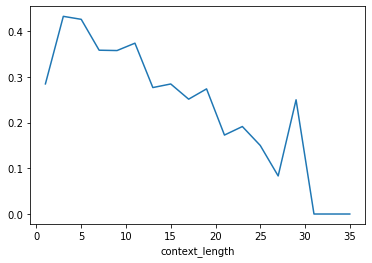

In [37]:
df.groupby('context_length')['entity_prec'].mean().plot()

<AxesSubplot:xlabel='context_length'>

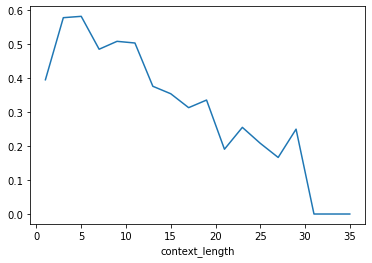

In [38]:
df.groupby('context_length')['entity_recall'].mean().plot()

<AxesSubplot:xlabel='context_length'>

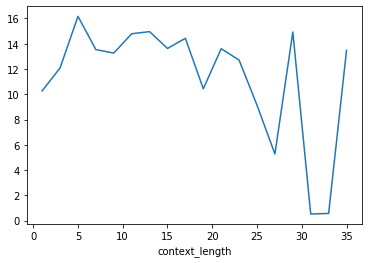

In [39]:
df.groupby('context_length')['bleu'].mean().plot()

Text(0.5, 1.0, 'Entity-F1 Score')

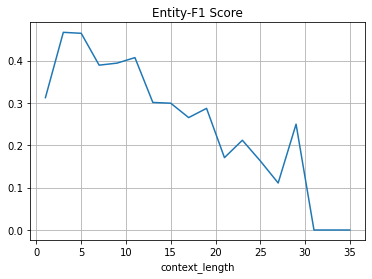

In [40]:
df.groupby('context_length')['entity_f1'].mean().plot()
plt.grid()
plt.title("Entity-F1 Score")

## [RESULT] Correctness of entities predicted

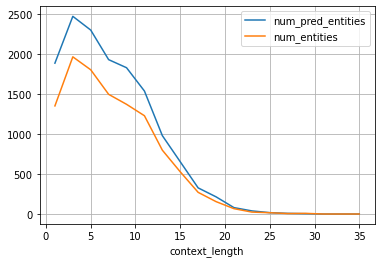

In [62]:
df.groupby('context_length')[['num_pred_entities', 'num_entities']].sum().plot()
plt.grid()

Text(0.5, 1.0, 'Histogram of Entity Precision')

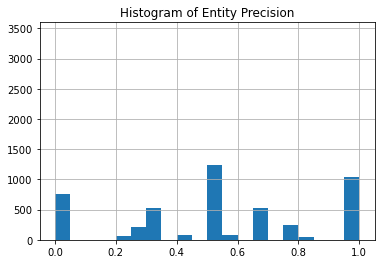

In [68]:
df.loc[df['num_entities']>0, ['entity_prec']].hist(bins=20)
plt.ylim(0, 3600)
plt.title("Histogram of Entity Precision")

Text(0.5, 1.0, 'Histogram of Entity Recall')

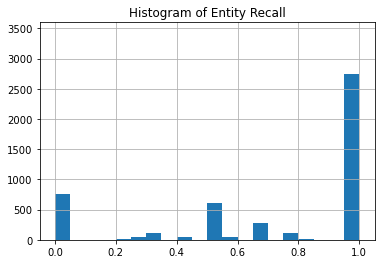

In [69]:
df.loc[df['num_entities']>0, ['entity_recall']].hist(bins=20)
plt.ylim(0, 3600)
plt.title("Histogram of Entity Recall")

## [EXP] People vs. Number of Entities

<AxesSubplot:xlabel='num_entities'>

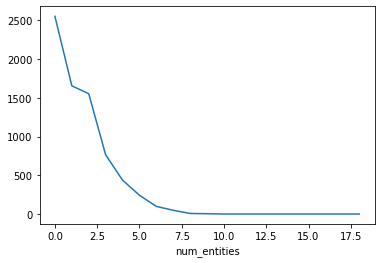

In [42]:
df.groupby('num_entities')['file'].count().plot()

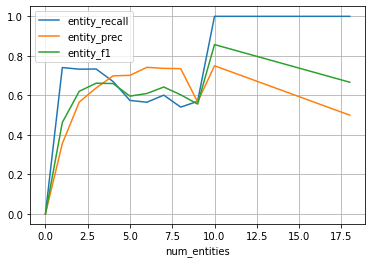

In [56]:
df.groupby('num_entities')[['entity_recall', 'entity_prec', 'entity_f1']].mean().plot()
plt.grid()

<AxesSubplot:xlabel='num_entities'>

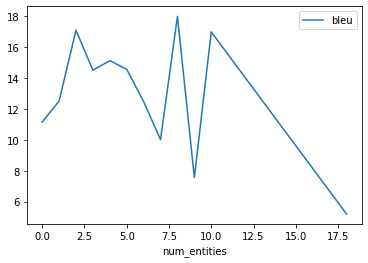

In [44]:
df.groupby('num_entities')[['bleu']].mean().plot()

(0.0, 15.0)

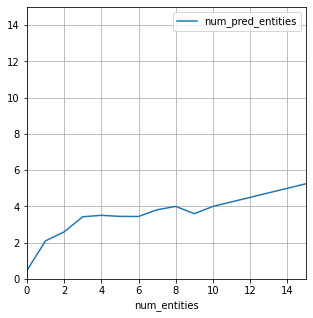

In [70]:
df.groupby('num_entities')[['num_pred_entities']].mean().plot(figsize=(5,5))
plt.grid()
plt.xlim((0, 15))
plt.ylim((0, 15))

### [DEFINE] Avg. Response Length

Mean response length: 18.44234943027672


(0.0, 50.0)

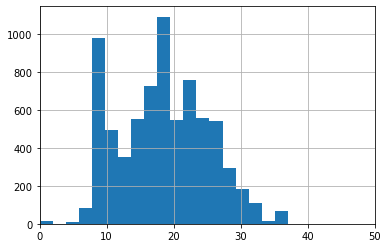

In [65]:
response_lengths = df.apply(lambda x: len(x["generated"].split()), 1)
print("Mean response length:", response_lengths.mean())
response_lengths.hist(bins=20)
plt.xlim(0, 50)

# Process Dialog level Stats (Inform/Success)

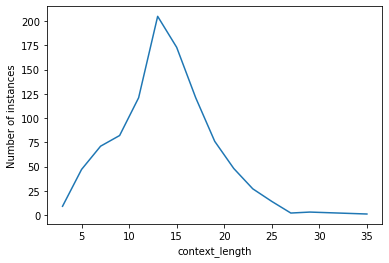

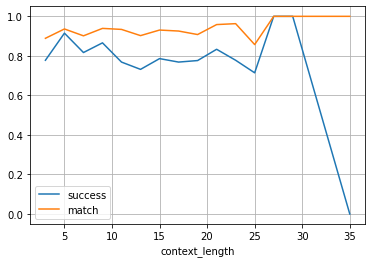

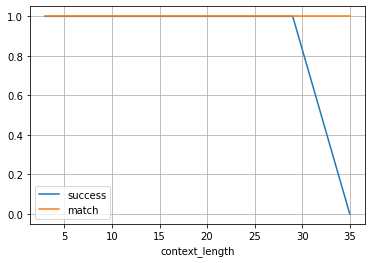

In [47]:
df_temp = df.groupby('file')[['context_length']].max().reset_index()
df_temp['file'] = df_temp.apply(lambda r: r['file']+'.json', 1)
df_combo = pd.merge(df_temp, df_stats, how='inner', on='file')

df_combo.groupby('context_length')['context_length'].count().plot()
plt.ylabel('Number of instances')

df_combo.groupby('context_length')[['success', 'match']].mean().plot()
plt.grid()

df_combo.groupby('context_length')[['success', 'match']].median().plot()
plt.grid()

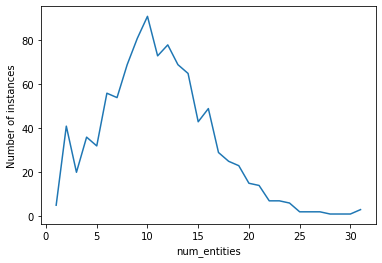

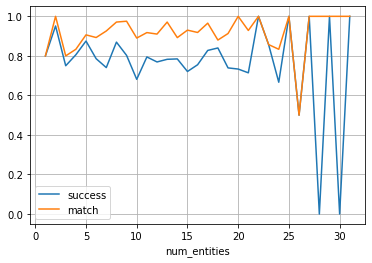

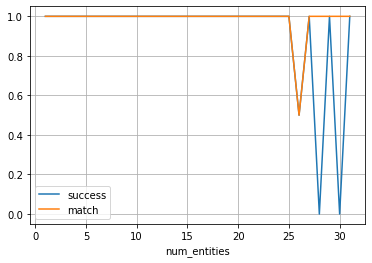

In [48]:
df_temp = df.groupby('file')[['num_entities']].sum().reset_index()
df_temp['file'] = df_temp.apply(lambda r: r['file']+'.json', 1)
df_combo = pd.merge(df_temp, df_stats, how='inner', on='file')

df_combo.groupby('num_entities')['num_entities'].count().plot()
plt.ylabel('Number of instances')

df_combo.groupby('num_entities')[['success', 'match']].mean().plot()
plt.grid()

df_combo.groupby('num_entities')[['success', 'match']].median().plot()
plt.grid()

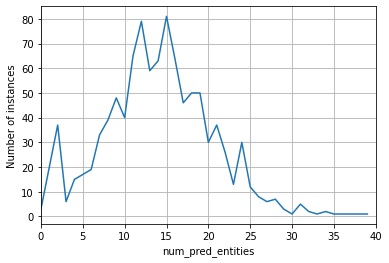

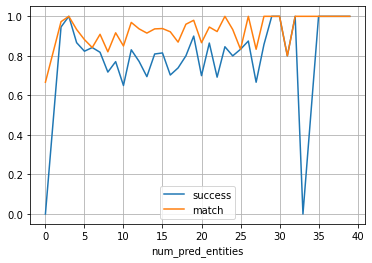

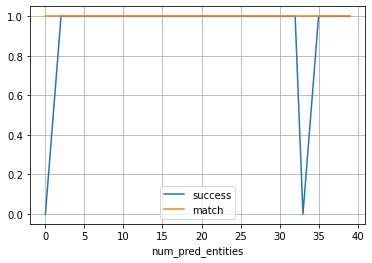

In [55]:
df_temp = df.groupby('file')[['num_pred_entities']].sum().reset_index()
df_temp['file'] = df_temp.apply(lambda r: r['file']+'.json', 1)
df_combo = pd.merge(df_temp, df_stats, how='inner', on='file')

df_combo.groupby('num_pred_entities')['num_pred_entities'].count().plot()
plt.grid(); plt.xlim(0, 40);
plt.ylabel('Number of instances')

df_combo.groupby('num_pred_entities')[['success', 'match']].mean().plot()
plt.grid()

df_combo.groupby('num_pred_entities')[['success', 'match']].median().plot()
plt.grid()

## Match/Success pairwise stats

In [50]:
for key, g in df_stats.groupby(['match', 'success']):
    print(key, g.shape[0], 'rows')

(0, 0) 77 rows
(1, 0) 137 rows
(1, 1) 786 rows


## Find dialogs by match/success constraints:

In [51]:
df2 = df.copy()
df2['file'] = df2.apply(lambda r: r['file']+'.json', 1)

In [52]:
df_full = df_stats.merge(df2, on=['file'])

In [53]:
for _, r in df_stats.iterrows():
    file = r['file']
    match = r['match']
    success = r['success']
    if match == 1 and success == 0:
        piece = df2[df2['file'] == file]
        showme = ['gold_entities', 'num_entities', 'pred_entities', 'num_pred_entities', 'entity_prec', 'entity_recall']
        
        print(f"{file}, Match: {match}, Success: {success}")
        for _, rc in piece.iterrows():
            print('-------------------------------')
            display(piece.loc[_, showme])
            print('-------------------------------')
            # print('[CON]', rc['context'])
            print('[GOLD]', rc['gold'])
            print('[GEN]', rc['generated'])
        break

MUL0003.json, Match: 1, Success: 0
-------------------------------


gold_entities        [value_count]
num_entities                     1
pred_entities        [value_count]
num_pred_entities                1
entity_prec                      1
entity_recall                    1
Name: 0, dtype: object

-------------------------------
[GOLD] there are [value_count] hotel -s that meet your needs . would you like to narrow your search by area and and or price range ?
[GEN] there are [value_count] hotel -s that meet your criteria . do you have a price range in mind ?
-------------------------------


gold_entities                                            [value_count]
num_entities                                                         1
pred_entities        [value_count, hotel_name, hotel_pricerange, ho...
num_pred_entities                                                    5
entity_prec                                                   0.333333
entity_recall                                                        1
Name: 1, dtype: object

-------------------------------
[GOLD] there are [value_count] guesthouse hotel -s in various area -s . what part of town are you hoping for ?
[GEN] there are [value_count] hotel -s that meet your criteria . the [hotel_name] is a [hotel_pricerange] -ly priced , and [hotel_name] is [value_count] stars .
-------------------------------


gold_entities        [value_count, value_count, value_count]
num_entities                                               3
pred_entities                 [hotel_name, hotel_pricerange]
num_pred_entities                                          2
entity_prec                                                0
entity_recall                                              0
Name: 2, dtype: object

-------------------------------
[GOLD] sure ! we will book you in a hotel with [value_count] stars . the reservation will be for [value_count] people for [value_count] nights . how many rooms would you like to reserve ?
[GEN] i would recommend the [hotel_name] . it s a [hotel_pricerange] -ly priced guesthouse . would you like me to book it for you ?
-------------------------------


gold_entities        [hotel_name, hotel_address, value_count, value...
num_entities                                                         6
pred_entities                                                       []
num_pred_entities                                                    0
entity_prec                                                          0
entity_recall                                                        0
Name: 3, dtype: object

-------------------------------
[GOLD] you are booked at the [hotel_name] , [hotel_address] , for [value_count] people for [value_count] nights tarting [value_day] . your reference number is [hotel_reference] .
[GEN] how many people will be staying ?
-------------------------------


gold_entities        [restaurant_name]
num_entities                         1
pred_entities        [restaurant_name]
num_pred_entities                    1
entity_prec                          1
entity_recall                        1
Name: 4, dtype: object

-------------------------------
[GOLD] i found [restaurant_name] would you like to book that ?
[GEN] i can book you at [restaurant_name] . would you like me to book you a table ?
-------------------------------


gold_entities        [restaurant_name]
num_entities                         1
pred_entities        [restaurant_area]
num_pred_entities                    1
entity_prec                          0
entity_recall                        0
Name: 5, dtype: object

-------------------------------
[GOLD] yes , the restaurant is called [restaurant_name] . would you like to book a table there ?
[GEN] it is located in the [restaurant_area] . would you like me to make a reservation for you ?
-------------------------------


gold_entities        [value_count, restaurant_name, value_day, valu...
num_entities                                                         5
pred_entities        [value_count, restaurant_name, restaurant_refe...
num_pred_entities                                                    3
entity_prec                                                          1
entity_recall                                                      0.6
Name: 6, dtype: object

-------------------------------
[GOLD] great ! your booking for [value_count] people at the restaurant [restaurant_name] on [value_day] at [value_time] was successful ! your reference number is [restaurant_reference] .
[GEN] i have booked you a table for [value_count] at [restaurant_name] . your reference number is [restaurant_reference] . is there anything else i can help you with ?
-------------------------------


gold_entities        [value_place]
num_entities                     1
pred_entities                   []
num_pred_entities                0
entity_prec                      0
entity_recall                    0
Name: 7, dtype: object

-------------------------------
[GOLD] thank you for using the [value_place] towneinfo help desk !
[GEN] you are welcome , have a great day !
